# Optimizing overall number of connections (algorithm test)<br>[Including data splits!]

<u>Goal</u>: Same overall #connections in rewired as in original connectome

ℹ️ Related ticket: https://bbpteam.epfl.ch/project/issues/browse/ACCS-46

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
save_figs = False

## Set up toy connectome and (inaccurate) conn. prob. model

* Toy connectome defined by adjacency matrix (specific instance)
* Conn. prob. model to be used for rewiring, defined by conn. prob. matrix (not entierly consistent with actual connectome)

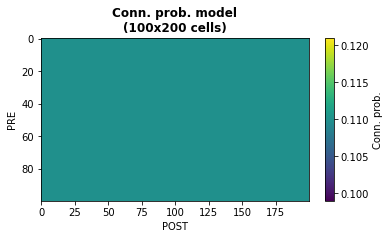

In [3]:
# Initialize model connection probabilities
N = 100 # Number of pre-neurons
M = 200 # Number of post-neurons

np.random.seed(0)
# p = np.array([0.5 * np.random.rand(N) * np.arange(N) * (m + 1) / (N * M) for m in range(M)]).T # Connection probabilities for NxM neurons with different pathway probability scalings
# p = np.array([0.5 * np.random.rand(N) * np.arange(N) / N for m in range(M)]).T # Connection probabilities for NxM neurons with same pathway probability scalings
# p = np.array([np.full(N, 0.5 * (m + 1) / M) for m in range(M)]).T # Constant connection probabilities for NxM neurons with different pathway probability scalings
p = np.array([np.full(N, 0.11) for m in range(M)]).T # Constant connection probabilities for NxM neurons with same pathway probability scalings

plt.figure(figsize=(6, 3))
plt.imshow(p, interpolation='nearest')
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.colorbar(label='Conn. prob.')
plt.title(f'Conn. prob. model\n({N}x{M} cells)', fontweight='bold')
if save_figs:
    plt.savefig('conn_prob_model.png', dpi=300)
plt.show()

INFO: #connections in original connectome: 2565 (=optimization target)


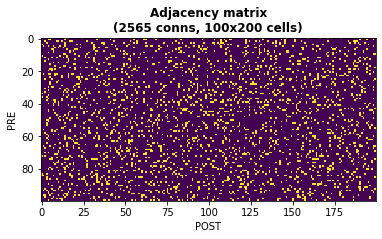

In [4]:
# Define original connectome (=optimization target), which is somewhat different from (inaccurate) model
model_mismatch_pct = -10.0
adj_orig = np.random.rand(*p.shape) < p * (1 - model_mismatch_pct / 100)
nconn_orig = np.sum(adj_orig)
print(f'INFO: #connections in original connectome: {nconn_orig} (=optimization target)')

plt.figure(figsize=(6, 3))
plt.imshow(adj_orig, interpolation='nearest')
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.title(f'Adjacency matrix\n({np.sum(adj_orig)} conns, {N}x{M} cells)', fontweight='bold')
if save_figs:
    plt.savefig('adj_mat_orig.png', dpi=300)
plt.show()

## Run rewiring with optimization of #connections

In [76]:
# Definition of data splits
def split_data(num_cells, num_splits=1):
    split_counts = [np.ceil(num_cells / num_splits).astype(int) for i in range(num_splits - 1)]
    split_counts.append(num_cells - np.sum(split_counts).astype(int))
    assert np.all(np.array(split_counts) > 0) and np.sum(split_counts) == num_cells, 'ERROR: Data splitting not possible! Try decreasing number of splits!'

    split_indices = []
    start = 0
    for n in range(num_splits):
        split_indices.append(np.arange(split_counts[n]) + start)
        start += split_counts[n]

    # print(f'Data split sizes ({num_splits} splits): {split_counts}')
    return split_indices, np.array(split_counts)

### Step 1: Matching the mean

- Exact solution (independent of data splits), or using error propagation within data splits
- Convergence check for different numbers of splits
- Closest solution, if convergence not possible (incl. predicted mismatch)

* Checking exact solution w/o error propagation (independent of splits)...
  No exact solution found (oscillating)!
  Closest solution: p_scale = 1.165909090909091, #conns = 2600, DIFF to orig: 35 (1.36%)
* Checking solution with error propagation (within 10 splits)...
  (Split sizes: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20])
  No exact solution found (oscillating)!
  Closest solution: p_scale = 1.165909090909091, #conns = 2560, DIFF to orig: -5 (-0.19%)
* Checking solution with error propagation (within 11 splits)...
  (Split sizes: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 10])
  No exact solution found (oscillating)!
  Closest solution: p_scale = 1.165909090909091, #conns = 2568, DIFF to orig: 3 (0.12%)
* Checking solution with error propagation (within 12 splits)...
  (Split sizes: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 13])
  Convergence after 1 steps!
  p_scale = 1.165909090909091
  num_splits = 12

OPTIMAL SOLUTION FOUND:
  num_splits = 12, p_scale = 1.165909090909091, #con

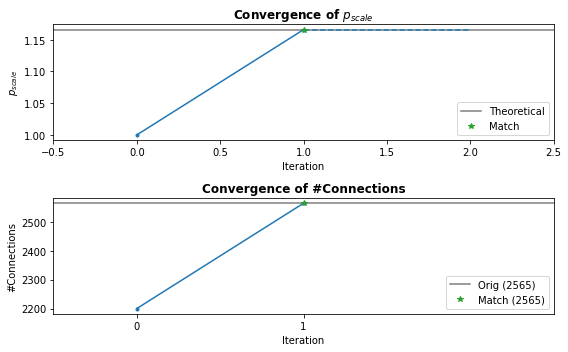

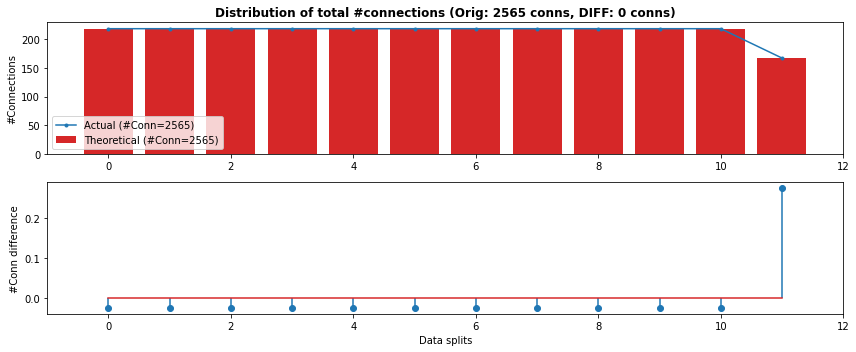

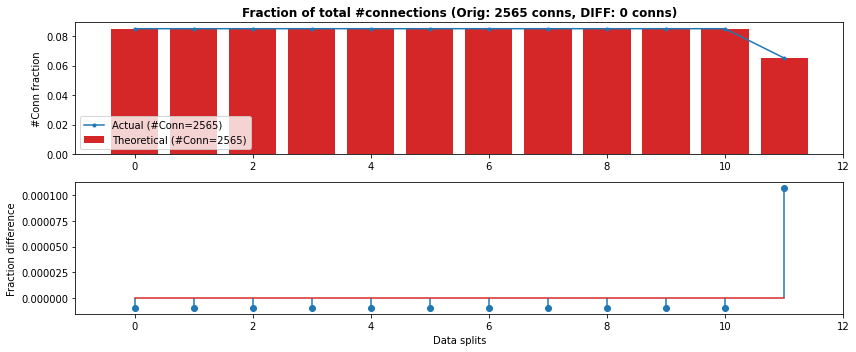

In [211]:
# Check if exact solution can be found (independent of data splits)
# [Convergence with rounding (since rewiring is done per post-neuron), i.e., if scaling factor exists so that total #connections matches w/o any error propagation]
# If no exact solution: Check convergence over splits, incl. error propagation within split

num_splits_range = [10, 15] # Range of numbers of data splits to find optimum (starting at lower values; None to skip splitting and aim for exact solution only)

NUM_ITER = 100 # Max. number of iterations to find solution
opt_num_splits = None
opt_nconns = None
opt_nconns_steps = None
opt_p_scale = None
opt_p_scale_steps = None
opt_conv_idx = None
opt_osc_idx = None
opt_opt_idx = None
num_splits_list = [None]
if num_splits_range is not None:
    assert isinstance(num_splits_range, list) and len(num_splits_range) == 2 and 0 < num_splits_range[0] <= num_splits_range[1] <= M, 'ERROR: Num data splits out of range!'
    num_splits_list += list(range(num_splits_range[0], num_splits_range[1] + 1))
for num_splits in num_splits_list:
    if num_splits is None:
        split_indices = None
        print('* Checking exact solution w/o error propagation (independent of splits)...')
    else:
        split_indices, split_counts = split_data(M, num_splits)
        print(f'* Checking solution with error propagation (within {num_splits} splits)...')
        print(f'  (Split sizes: {split_counts})')
    p_scale = 1.0
    p_scale_steps = [p_scale]
    nconns_steps = []
    conv_idx = None
    osc_idx = None
    for n in range(NUM_ITER):
        assert np.max(p * p_scale) <= 1.0, 'ERROR: p out of range!'
        if split_indices is None: # Check exact solution w/o error propagation (independent of splits)
            nconns = np.sum(np.round(np.sum(p * p_scale, 0)).astype(int))
        else: # Check solution with error propagation (within splits)
            nconns = np.sum([np.round(np.sum(p[:, split] * p_scale)) for split in split_indices])
        nconns_steps.append(nconns)
        p_scale = p_scale * (nconn_orig / nconns)
        p_scale_steps.append(p_scale)
        if np.round(nconns).astype(int) == nconn_orig:
            conv_idx = n
            print(f'  Convergence after {conv_idx} steps!')
            print(f'  p_scale = {p_scale}')
            print(f'  num_splits = {num_splits}')
            if opt_conv_idx is None: # Only update, if optimum not yet found (i.e., keeping first optimal solution)
                opt_num_splits = num_splits
                opt_p_scale = p_scale
                opt_p_scale_steps = p_scale_steps
                opt_nconns = np.round(nconns).astype(int)
                opt_nconns_steps = nconns_steps
                opt_conv_idx = conv_idx
                opt_osc_idx = osc_idx
            break
        elif nconns in nconns_steps[:-2] and nconns != nconns_steps[-2]:
            osc_idx = np.hstack([np.where(nconns_steps[:-2] == nconns)[0][-1], n])
            print(f'  No exact solution found (oscillating)!')
            opt_idx = np.argmin(np.abs(np.array(nconns_steps) - nconn_orig))
            print(f'  Closest solution: p_scale = {p_scale_steps[opt_idx]}, #conns = {np.round(nconns_steps[opt_idx]).astype(int)}, DIFF to orig: {np.round(nconns_steps[opt_idx]).astype(int) - nconn_orig} ({100.0 * (np.round(nconns_steps[opt_idx]) - nconn_orig) / nconn_orig:.2f}%)')
            if opt_nconns is None or np.abs(np.round(nconns_steps[opt_idx]).astype(int) - nconn_orig) < np.abs(opt_nconns - nconn_orig): # Keep better solution:
                opt_num_splits = num_splits
                opt_p_scale = p_scale_steps[opt_idx]
                opt_p_scale_steps = p_scale_steps
                opt_nconns = np.round(nconns_steps[opt_idx]).astype(int)
                opt_nconns_steps = nconns_steps
                opt_conv_idx = conv_idx
                opt_osc_idx = osc_idx
                opt_opt_idx = opt_idx
            break
    if conv_idx is not None:
        break
    assert osc_idx is not None, '  ERROR: Not enough iterations to determine convergence!'
if conv_idx is None:
    if num_splits_range is None:
        print(f'\nWARNING: No exact solution found w/o error propagation!')
    else:
        print(f'\nWARNING: No exact solution found for no & {"..".join(np.unique(num_splits_range).astype(str))} data splits!')
    print('CLOSEST SOLUTION FOUND:')
else:
    print('\nOPTIMAL SOLUTION FOUND:')
print((f'  num_splits = {opt_num_splits}' if opt_num_splits is not None else '  No splits (w/o error propagation)') + f', p_scale = {opt_p_scale}, #conns = {opt_nconns}, DIFF to orig: {opt_nconns - nconn_orig} ({100.0 * (opt_nconns - nconn_orig) / nconn_orig:.2f}%)')


# Plot p_scale convergence
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
xlim = [-0.5, len(opt_p_scale_steps) - 0.5]
plt.plot(xlim, np.full(2, nconn_orig / np.sum(p)), '-', color='tab:grey', zorder=0, label='Theoretical')
if opt_conv_idx is None:
    plt.plot(np.arange(len(opt_p_scale_steps)), opt_p_scale_steps, '.-', color='tab:blue')
    plt.plot(opt_opt_idx, opt_p_scale_steps[opt_opt_idx], '*', color='tab:olive', label=f'Closest')
else:
    plt.plot(np.arange(opt_conv_idx + 1), opt_p_scale_steps[:opt_conv_idx + 1], '.-', color='tab:blue')
    plt.plot(np.arange(opt_conv_idx, len(opt_p_scale_steps)), opt_p_scale_steps[opt_conv_idx:], '--', color='tab:blue')
    plt.plot(opt_conv_idx, opt_p_scale_steps[opt_conv_idx], '*', color='tab:green', label=f'Match')
plt.xlim(xlim)
plt.xlabel('Iteration')
plt.ylabel('$p_{scale}$')
plt.title(f'Convergence of ' + '$p_{scale}$', fontweight='bold')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(opt_nconns_steps)), opt_nconns_steps, '.-', color='tab:blue')
plt.xlim(xlim)
plt.plot(plt.xlim(), np.full(2, nconn_orig), '-', color='tab:grey', zorder=0, label=f'Orig ({nconn_orig})')
if opt_conv_idx is not None:
    plt.plot(opt_conv_idx, opt_nconns_steps[opt_conv_idx], '*', color='tab:green', label=f'Match ({np.round(opt_nconns_steps[opt_conv_idx]).astype(int)})')
if opt_osc_idx is not None:
    plt.plot(opt_osc_idx, np.array(opt_nconns_steps)[opt_osc_idx], 'o', color='tab:red')
    plt.plot(opt_opt_idx, opt_nconns_steps[opt_opt_idx], '*', color='tab:olive', label=f'Closest ({np.round(opt_nconns_steps[opt_opt_idx]).astype(int)})')
plt.xticks(np.arange(len(opt_nconns_steps)))
plt.xlabel('Iteration')
plt.ylabel('#Connections')
plt.title(f'Convergence of #Connections', fontweight='bold')
plt.legend(loc='lower right')
plt.tight_layout()
if save_figs:
    plt.savefig('convergence.png', dpi=300)
plt.show()


# Plot pathway counts
if opt_num_splits is None:
    est_nconns = np.sum(p * opt_p_scale, 0) # Estimated (theoretical) #conns per POST-neuron
else:
    opt_split_indices, _ = split_data(M, opt_num_splits)
    est_nconns = np.array([np.sum(p[:, split] * opt_p_scale) for split in opt_split_indices]) # Estimated (theoretical) #conns per split
act_nconns = np.round(est_nconns) # Actual #conns (rounded per split/POST-neuron)
est_nconns_fract = est_nconns / nconn_orig # Estimated (theoretical) fraction
act_nconns_fract = act_nconns / nconn_orig # Actual fraction

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
bin_centers = np.arange(len(est_nconns))
plt.bar(bin_centers, est_nconns, align='center', color='tab:red', label=f'Theoretical (#Conn={np.round(np.sum(est_nconns)).astype(int)})')
plt.plot(bin_centers, act_nconns, '.-', color='tab:blue', label=f'Actual (#Conn={np.round(np.sum(act_nconns)).astype(int)})')
xlim = [-1.0, len(est_nconns)]
plt.xlim(xlim)
if np.max(act_nconns) < 100:
    # Plot grid with possible values
    for n in np.arange(np.max(act_nconns)) + 1:
        plt.plot(xlim, np.full(2, n), '-', color='grey', lw=1, alpha=0.25, zorder=0)
plt.ylabel('#Connections')
plt.title(f'Distribution of total #connections (Orig: {nconn_orig} conns, DIFF: {opt_nconns - nconn_orig} conns)', fontweight='bold')
plt.legend()

plt.subplot(2, 1, 2)
plt.stem(bin_centers, act_nconns - est_nconns, label=f'Actual (#Conn={np.round(np.sum(act_nconns)).astype(int)})')
plt.xlim(xlim)
if opt_num_splits is None:
    plt.xlabel('POST-neurons')
else:
    plt.xlabel('Data splits')
plt.ylabel('#Conn difference')
plt.tight_layout()
if save_figs:
    plt.savefig('nconns_distribution.png', dpi=300)
plt.show()


# Plot pathway fractions
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
bin_centers = np.arange(len(est_nconns))
plt.bar(bin_centers, est_nconns_fract, align='center', color='tab:red', label=f'Theoretical (#Conn={np.round(np.sum(est_nconns)).astype(int)})')
plt.plot(bin_centers, act_nconns_fract, '.-', color='tab:blue', label=f'Actual (#Conn={np.round(np.sum(act_nconns)).astype(int)})')
xlim = [-1.0, len(est_nconns_fract)]
plt.xlim(xlim)
if np.max(act_nconns) < 100:
    # Plot grid with possible values
    for n in np.arange(np.max(act_nconns)) + 1:
        plt.plot(xlim, np.full(2, n / nconn_orig), '-', color='grey', lw=1, alpha=0.25, zorder=0)
plt.ylabel('#Conn fraction')
plt.title(f'Fraction of total #connections (Orig: {nconn_orig} conns, DIFF: {opt_nconns - nconn_orig} conns)', fontweight='bold')
plt.legend()

plt.subplot(2, 1, 2)
plt.stem(bin_centers, act_nconns_fract - est_nconns_fract, label=f'Actual (#Conn={np.round(np.sum(act_nconns)).astype(int)})')
plt.xlim(xlim)
if opt_num_splits is None:
    plt.xlabel('POST-neurons')
else:
    plt.xlabel('Data splits')
plt.ylabel('Fraction difference')
plt.tight_layout()
if save_figs:
    plt.savefig('nconns_fraction.png', dpi=300)
plt.show()


In [ ]:
# TODO: Plot error propagation & fraction within data splits

## Alternative solution: Oversampling & pruning

<u>Given</u>:
- Number of data splits
- Oversampling factor (such that produced number of connections is larger or equal than target number)

<u>Approach</u>:
- Step 1a: Estimation run, returning oversampled numbers of connections per split `nconns_per_split`
- Step 1b: Calculation of pruning counts `pruning_counts`, i.e., numbers of connections to be removed in each split
- Step 2a: Actual rewiring run
- Step 2b: Apply pruning to each data split, i.e., remove connections in each data split according to `pruning_counts`

<u>Note</u>: For Step 2b, `pruning_counts` must be passed to the pruning operation

In [258]:
num_splits = 10
p_scale = 1.2  # Oversampling factor

In [259]:
# Determine actual connections (with oversampling)
split_indices, split_counts = split_data(M, num_splits)
nconns_per_split = np.array([np.sum(np.round(np.sum(p[:, split] * p_scale, 0)).astype(int)) for split in split_indices])
nconns = np.sum(nconns_per_split)

assert nconns >= nconn_orig, "ERROR: Pruning not possible! Please increase oversampling factor."

In [260]:
# Determine number of connections to be removed per split (pruning)
pruning_factor = nconn_orig / nconns
nconns_per_split_pruned_opt = pruning_factor * nconns_per_split  # Optimal (theoretical) count
nconns_per_split_pruned = np.round(pruning_factor * nconns_per_split).astype(int)  # Actual count, with rounding

ndiff = np.sum(nconns_per_split_pruned) - nconn_orig
rel_rounding_err = (nconns_per_split_pruned - nconns_per_split_pruned_opt) / nconns_per_split_pruned_opt
if ndiff > 0:
    # Randomly remove ndiff connections to compensate for rounding errors
    # (selection probability based on rel. error from opt. count)
    p_rmv = rel_rounding_err * (rel_rounding_err > 0)
    p_rmv = p_rmv / np.sum(p_rmv)
    rmv_idx = np.random.choice(len(p_rmv), ndiff, replace=False, p=p_rmv)
    nconns_per_split_pruned[rmv_idx] -= 1
elif ndiff < 0:
    # Randomly add back ndiff connections to compensate for rounding errors
    # (selection probability based on rel. error from opt. count)
    p_add = np.abs(rel_rounding_err) * (rel_rounding_err < 0)
    p_add = p_add / np.sum(p_add)
    add_idx = np.random.choice(len(p_add), np.abs(ndiff), replace=False, p=p_add)
    nconns_per_split_pruned[add_idx] += 1

assert np.sum(nconns_per_split_pruned) == nconn_orig, "ERROR: Connection count mismatch!"

pruning_counts = nconns_per_split_pruned - nconns_per_split  # Pruning counts per split (= number of connections to be removed)
print(f"Target number of connections: {nconn_orig}")
print(f"Oversampled number of connections: {nconns_per_split} = {np.sum(nconns_per_split)}")
print(f"Pruning counts: {pruning_counts}")
print(f"Pruned number of connections: {nconns_per_split_pruned} = {np.sum(nconns_per_split_pruned)}")

Target number of connections: 2565
Oversampled number of connections: [260 260 260 260 260 260 260 260 260 260] = 2600
Pruning counts: [-4 -3 -4 -4 -3 -4 -3 -3 -3 -4]
Pruned number of connections: [256 257 256 256 257 256 257 257 257 256] = 2565


In [2]:
# PROBLEM: Keeping track of newly generated connections in oversampling run to remove from during pruning run (?)